## Блок импорта ##

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

## Генерация данных ##

Двумерные

In [2]:
df = make_blobs(n_features = 2, centers = 2)

In [3]:
X, y = df

Поскольку используется линейный алгоритм, то Иксы нужно нормализовать

In [4]:
def scale(X: np.array or list) -> np.array:
    X = np.array(X)
    return (X - np.mean(X, axis = 0)) / np.std(X, axis = 0)

In [5]:
X_scaled = scale(X)

Игреки необходимо привести игреки к промежутку [-1,1]

In [6]:
y_scaled = np.where(y == 0, -1, 1)
y_scaled

array([-1, -1,  1, -1, -1,  1,  1, -1, -1, -1, -1, -1, -1,  1,  1,  1, -1,
        1,  1,  1,  1, -1, -1, -1, -1,  1, -1,  1, -1,  1, -1, -1,  1,  1,
       -1,  1,  1,  1,  1,  1, -1, -1,  1,  1, -1,  1, -1,  1, -1, -1,  1,
       -1, -1,  1, -1, -1, -1,  1,  1,  1, -1,  1,  1, -1,  1, -1, -1, -1,
        1,  1, -1, -1,  1,  1,  1,  1,  1, -1, -1, -1,  1,  1,  1,  1, -1,
        1, -1,  1,  1, -1, -1,  1,  1,  1,  1, -1, -1, -1, -1, -1])

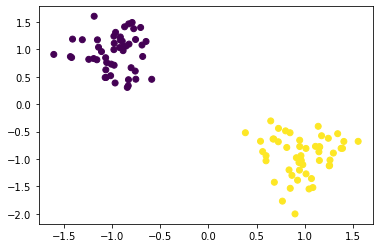

In [7]:
plt.scatter(X_scaled[:,0], X_scaled[:,1], c = y_scaled)

## Реализация класса SVM_C ##

In [12]:
class SVM_C(object):
    def __init__(self, soft: bool = False, epochs: int = 130, etha: float = 0.01, alpha: float = 0.1, use_bias: bool = True) -> None:
        self.soft = soft
        self.epochs = epochs
        self.etha = etha
        self.alpha = alpha
        self.use_bias = use_bias
        self.w = []
    
    def add_bias(self, X: np.array) -> np.array:
        """
        Функция, реализующая добавление члена смещения b.
        """
        biased_X = np.ones((X.shape[0], X.shape[1] + 1))
        biased_X[:, :-1] = X
        return biased_X
        
    def hinge_loss(self, x: np.array or list, y: float, w: np.array or list) -> float:
        x = np.array(x)
        w = np.array(w)
        return max(0, 1 - y * np.dot( (w.T), x ))
        
    def soft_loss(self, x: np.array or list, y: float, w: np.array or list, alpha: float) -> float:
        x = np.array(x)
        w = np.array(w)
        return self.hinge_loss(x, y, w) + ( alpha * np.dot(w.T, w) / 2 )
        
    def fit(self, X: np.array or list, y: np.array or list) -> np.array:
        assert (X.shape[0] == y.shape[0]), 'Shape of X must be equal shape of y'
        
        history = []
        
        # добавление члена смещения
        if ( self.use_bias == True ):
            X = self.add_bias(X)
        
        # инициализация весов
        weights = np.random.normal(loc = 0, scale = 0.05, size = X.shape[1])
        
        # пройти заданное количество эпох
        for epoch in range( self.epochs ):
            error = 0
            for idx in range( len( X ) ):
                # высчитывание зазора
                margin = y[idx] * np.dot( weights.T, X[idx] )
                
                if (margin >= 1): # если классификатор сработал правильно
                    
                    if (self.soft == False): # для твердого
                        # в случае твердой классификации ничего не меняется
                        pass
                    else: # для мягкого
                        # в случае мягкой классификации веса текут даже при правильной классификации
                        weights = weights - self.etha * ( self.alpha * weights )
                        
                else: # если классификатор сработал неправильно
                    if (self.soft == False): # для твердого
                        # здесь должен быть именно плюс
                        weights = weights + self.etha * y[idx] * X[idx] # градиент от hinge_Loss
                    else: # для мягкого
                        weights = weights - self.etha * ( self.alpha * weights - y[idx] * X[idx] ) # градиент от soft_loss
                
                # теперь пусть запишутся метрики
                if (self.soft == False):
                    error += ( self.hinge_loss(X[idx], y[idx], weights) )
                else:
                    error += ( self.soft_loss(X[idx], y[idx], weights, self.alpha) )
            history.append(error)
        
        self.w = weights
        
        return history

**Создание экземпляра и обучение модели**

In [13]:
svm = SVM_C(soft = False, epochs = 130, etha = 0.1, alpha = 0.1, use_bias = True)
history = svm.fit(X_scaled, y_scaled)

**Визуализация разделяющей поверхности**

Код для визуализации взял отсюда: (в целом, хорошая статья)
https://habr.com/ru/company/ods/blog/484148/

In [14]:
def newline(p1, p2, color=None):
    ax = plt.gca()
    xmin, xmax = ax.get_xbound()

    if(p2[0] == p1[0]):
        xmin = xmax = p1[0]
        ymin, ymax = ax.get_ybound()
    else:
        ymax = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmax-p1[0])
        ymin = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmin-p1[0])

    l = mlines.Line2D([xmin,xmax], [ymin,ymax], color=color)
    ax.add_line(l)
    return l

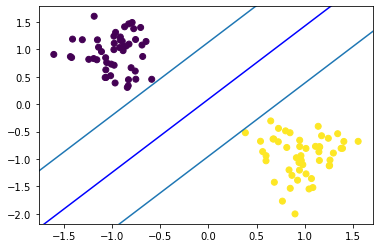

In [16]:
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=y_scaled)
newline([0,-svm.w[2]/svm.w[1]],[-svm.w[2]/svm.w[0],0], 'blue')
newline([0,1/svm.w[1]-svm.w[2]/svm.w[1]],[1/svm.w[0]-svm.w[2]/svm.w[0],0])
newline([0,-1/svm.w[1]-svm.w[2]/svm.w[1]],[-1/svm.w[0]-svm.w[2]/svm.w[0],0])
plt.show()

Можно немного сгладить границу

In [17]:
svm = SVM_C(soft = True, epochs = 130, etha = 0.1, alpha = 0.01, use_bias = True)
history = svm.fit(X_scaled, y_scaled)

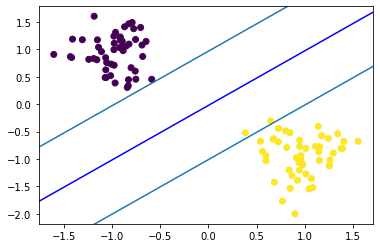

In [18]:
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=y_scaled)
newline([0,-svm.w[2]/svm.w[1]],[-svm.w[2]/svm.w[0],0], 'blue')
newline([0,1/svm.w[1]-svm.w[2]/svm.w[1]],[1/svm.w[0]-svm.w[2]/svm.w[0],0])
newline([0,-1/svm.w[1]-svm.w[2]/svm.w[1]],[-1/svm.w[0]-svm.w[2]/svm.w[0],0])
plt.show()

**Но интереснее попробовать линейно неразделимые данные**

In [47]:
df_non_lin = make_blobs(n_features = 2, centers = 2)
X_nl, y_nl = df_non_lin
X_nl_scaled = scale(X_nl)
y_nl_scaled = np.where(y_nl == 0, -1, 1)

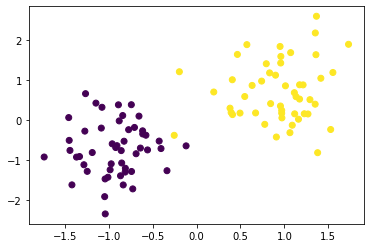

In [48]:
plt.scatter(X_nl_scaled[:,0], X_nl_scaled[:,1], c = y_nl_scaled)

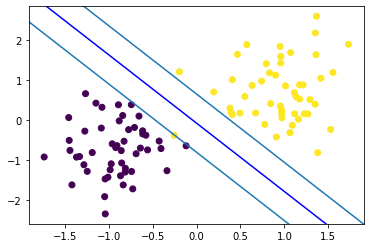

In [50]:
svm_nl = SVM_C(soft = False, epochs = 130, etha = 0.1, alpha = 0.1, use_bias = True)
history = svm_nl.fit(X_nl_scaled, y_nl_scaled)

plt.scatter(X_nl_scaled[:,0], X_nl_scaled[:,1], c=y_nl_scaled)
newline([0,-svm_nl.w[2]/svm_nl.w[1]],[-svm_nl.w[2]/svm_nl.w[0],0], 'blue')
newline([0,1/svm_nl.w[1]-svm_nl.w[2]/svm_nl.w[1]],[1/svm_nl.w[0]-svm_nl.w[2]/svm_nl.w[0],0])
newline([0,-1/svm_nl.w[1]-svm_nl.w[2]/svm_nl.w[1]],[-1/svm_nl.w[0]-svm_nl.w[2]/svm_nl.w[0],0])
plt.show()

Один элемент неправильно классификцирован, хотя сама поверхность выглядит вполне приятной

Теперь мягкий зазор

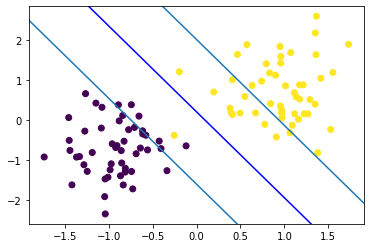

In [51]:
svm_nl = SVM_C(soft = True, epochs = 130, etha = 0.1, alpha = 0.1, use_bias = True)
history = svm_nl.fit(X_nl_scaled, y_nl_scaled)

plt.scatter(X_nl_scaled[:,0], X_nl_scaled[:,1], c=y_nl_scaled)
newline([0,-svm_nl.w[2]/svm_nl.w[1]],[-svm_nl.w[2]/svm_nl.w[0],0], 'blue')
newline([0,1/svm_nl.w[1]-svm_nl.w[2]/svm_nl.w[1]],[1/svm_nl.w[0]-svm_nl.w[2]/svm_nl.w[0],0])
newline([0,-1/svm_nl.w[1]-svm_nl.w[2]/svm_nl.w[1]],[-1/svm_nl.w[0]-svm_nl.w[2]/svm_nl.w[0],0])
plt.show()